# References/Web Search Cookbook 

## Introduction
The primary objective of this cookbook is to illustrate how to effectively use the lastest [Mistral Large 2](https://docs.mistral.ai/getting-started/models/models_overview/#premier-models) model to conduct **web searches** and incorporate relevant sources into your responses. A common challenge with chatbots and Retrieval-Augmented Generation (RAG) systems is their **tendency to hallucinate sources or improperly format URLs**. Mistral's advanced capabilities address these issues, ensuring accurate and reliable information retrieval.

## Mistral's Web Search Capabilities
The new Mistral model `mistral-large-latest` integrates web search capabilities, allowing it to **reference sources accurately in its responses**. This feature enables you to retrieve the source content and present it correctly in your responses, enhancing the reliability and credibility of the information provided. By leveraging Mistral's advanced natural language processing and web search integration, you can build more robust and trustworthy applications.


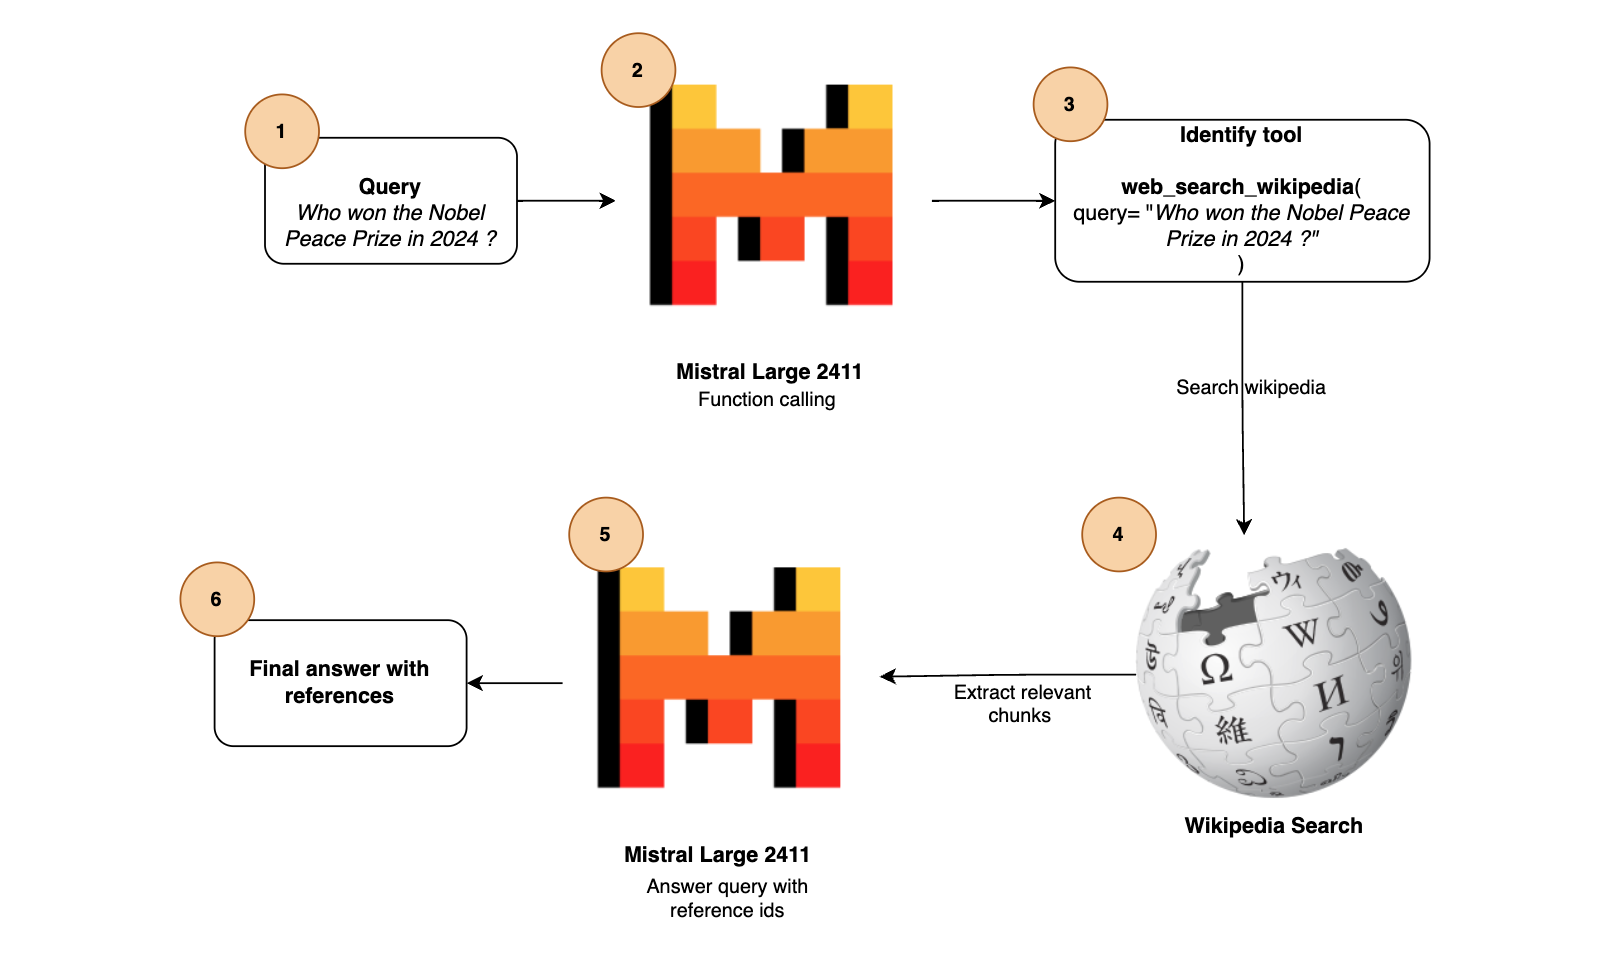

Here is a step-by-step description of the process depicted in the image above:
1. **Query Initiation**: The process begins with a user query.

2. **Function Calling with Mistral Large**: The query is processed by the Mistral Large model, which identifies that it needs to perform a function call to gather more information. This step involves determining the appropriate tool to use for the query.

3. **Tool Identification**: The Mistral model identifies the relevant tool for the query, which in this case is `web_search_wikipedia`. The tool has the user query as an argument.

4. **Wikipedia Search**: The tool is called and performs a search on Wikipedia using the query. 

5. **Extract Relevant Chunks**: The results from the Wikipedia search are processed to extract relevant chunks of information. These chunks are then prepared to be used as references in the final answer.

6. **Final Answer with References**: The chat history is sent to the Mistral Large model which uses the extracted chunks to generate a final answer. The answer includes references to the Wikipedia articles, ensuring that the information provided is accurate and well-sourced.



In [83]:
!pip install mistralai wikipedia


## Step 1: Initialize the Mistral client

In this step, we initialize the Mistral client with your API key. You can get or create your API key from the [Mistral API dashboard](https://console.mistral.ai/api-keys/).


In [9]:
from mistralai import Mistral
from mistralai.models import  UserMessage, SystemMessage
import os

client = Mistral(
    api_key=os.environ["MISTRAL_API_KEY"],
)


query = "Who won the Nobel Peace Prize in 2024?"

#Add the user message to the chat_history
chat_history = [
    SystemMessage(content="You are a helpful assistant that can search the web for information. Use context to answer the question."),
    UserMessage(content=query),
]




## Step 2 : Define the function calling tool to search Wikipedia.

[Function calling](https://docs.mistral.ai/capabilities/function_calling/) allows Mistral models to connect to external tools. By integrating Mistral models with external tools such as user defined functions or APIs, users can easily build applications catering to specific use cases and practical problems.

First, we create a tool that will search the Wikipedia API and return the results in a specific format. Once we have the tool, we can use it in a chat completion request to Mistral. The result should contain:

- Name of the tool
- Tool call ID
- Arguments which contains the user query


In [10]:
web_search_tool = {
    "type": "function",
    "function": {
        "name": "web_search",
        "description": "Search the web for a query for which you do not know the answer",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query to search the web in keyword form.",
                }
            },
            "required": ["query"],
        },
    },
}



chat_response = client.chat.complete(
    model="mistral-large-latest",
    messages=chat_history,
    tools=[web_search_tool],
)


if hasattr(chat_response.choices[0].message, 'tool_calls'):
    tool_call = chat_response.choices[0].message.tool_calls[0]
    chat_history.append(chat_response.choices[0].message)
    print(tool_call)
else:
    print("No tool call found in the response")

function=FunctionCall(name='web_search', arguments='{"query": "Nobel Peace Prize 2024 winner"}') id='5DR06FL8I' type='function'


## Step 3: Define Method to Search Wikipedia Associated with the Tool

In the previous step, we created a tool called `web_search_wikipedia`. We need to create a function that will take the tool call ID and the arguments and return the results in the specific format.

The format of the results should be:
```python
{
    "url": str | None,        # Page URL
    "title": str | None,      # Page title 
    "description": str | None, # Page description
    "snippets": List[str],    # Relevant text snippets in a list
    "date": str | None,       # date
    "source": str | None,      # Source/reference
    "metadata": Dict[str, Any] # Metadata
}
```

In [11]:
import wikipedia
import json
from datetime import datetime


def get_wikipedia_search(query: str) -> str:
    """
    Search Wikipedia for a query and return the results in a specific format.
    """
    result = wikipedia.search(query, results = 20)
    data={}
    for i, res in enumerate(result):
        pg= wikipedia.page(res, auto_suggest=False)
        data[i]={
            "url": pg.url,
            "title": pg.title,
            "snippets": [pg.summary.split('.')],
            "description": None,
            "date": datetime.now().isoformat(),
            "source": "wikipedia"
        }
    return json.dumps(data, indent=2)

## Step 4: Perform the Tool Call and Search Wikipedia
Now that we have the tool call ID and the arguments, we can perform the tool call and search Wikipedia.

In [12]:

import json
from mistralai import ToolMessage


query = json.loads(tool_call.function.arguments)["query"]
wb_result = get_wikipedia_search(query)

tool_call_result = ToolMessage(
    content=wb_result,
    tool_call_id=tool_call.id,
    name=tool_call.function.name,
)


# Append the tool call message to the chat_history
chat_history.append(tool_call_result)

#See chunks in the response
print(json.dumps(json.loads(wb_result), indent=2))

{
  "0": {
    "url": "https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize",
    "title": "2024 Nobel Peace Prize",
    "snippets": [
      [
        "The 2024 Nobel Peace Prize, an international peace prize established according to Alfred Nobel's will, was awarded to Nihon Hidankyo (the Japan Confederation of A- and H-Bomb Sufferers Organizations), for their activism against nuclear weapons, assisted by victim/survivors (known as Hibakusha) of the atomic bombings of Hiroshima and Nagasaki in 1945",
        " They will receive the prize at a ceremony on 10 December 2024 at Oslo, Norway",
        ""
      ]
    ],
    "description": null,
    "date": "2024-11-26T11:33:15.346105",
    "source": "wikipedia"
  },
  "1": {
    "url": "https://en.wikipedia.org/wiki/List_of_Nobel_Peace_Prize_laureates",
    "title": "List of Nobel Peace Prize laureates",
    "snippets": [
      [
        "The Norwegian Nobel Committee awards the Nobel Peace Prize annually \"to the person who shall have done 

## Step 5: Call Mistral with the Tool Call Result
The chat history now contains:

- The `System` message which contains the instructions for the assistant
- The `User` message which contains the original question
- The `Assistant` message which contains a tool call to search Wikipedia
- The `Tool call` result which contains the results of the Wikipedia search

See more information about types of messages [here](https://docs.mistral.ai/capabilities/completion/#chat-messages).


In [13]:
for msg in chat_history:
    print(msg,end='\n')

content='You are a helpful assistant that can search the web for information. Use context to answer the question.' role='system'
content='Who won the Nobel Peace Prize in 2024?' role='user'
content='' tool_calls=[ToolCall(function=FunctionCall(name='web_search', arguments='{"query": "Nobel Peace Prize 2024 winner"}'), id='5DR06FL8I', type='function')] prefix=False role='assistant'
content='{\n  "0": {\n    "url": "https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize",\n    "title": "2024 Nobel Peace Prize",\n    "snippets": [\n      [\n        "The 2024 Nobel Peace Prize, an international peace prize established according to Alfred Nobel\'s will, was awarded to Nihon Hidankyo (the Japan Confederation of A- and H-Bomb Sufferers Organizations), for their activism against nuclear weapons, assisted by victim/survivors (known as Hibakusha) of the atomic bombings of Hiroshima and Nagasaki in 1945",\n        " They will receive the prize at a ceremony on 10 December 2024 at Oslo, Norway",\n  

In [14]:
from mistralai.models import TextChunk, ReferenceChunk

def format_response(chat_response: list, wb_result:dict):
    print("\n🤖 Answer:\n")
    refs_used = []
    
    # Print the main response
    for chunk in chat_response.choices[0].message.content:
        if isinstance(chunk, TextChunk):
            print(chunk.text, end="")
        elif isinstance(chunk, ReferenceChunk):
            refs_used += chunk.reference_ids
        
    
    # Print references
    if refs_used:
        print("\n\n📚 Sources:")
        for i, ref in enumerate(set(refs_used), 1):
            reference = json.loads(wb_result)[str(ref)]
            print(f"\n{i}. {reference['title']}:{reference['url']}")
            

# Use the formatter
chat_response = client.chat.complete(
    model="mistral-large-latest",
    messages=chat_history,
    tools=[web_search_tool],
)
format_response(chat_response, wb_result)


🤖 Answer:

Nihon Hidankyo, a Japanese organization representing survivors of the Hiroshima and Nagasaki atomic bombings, was awarded the 2024 Nobel Peace Prize for their efforts to promote a world free of nuclear weapons and for sharing witness testimonies to ensure that nuclear weapons are never used again.

📚 Sources:

1. 2024 Nobel Peace Prize:https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize

2. Nobel Peace Prize:https://en.wikipedia.org/wiki/Nobel_Peace_Prize


## Step 6 : Streaming completion with references



In [15]:
stream_response = client.chat.stream(
    model="mistral-large-2411",
    messages=chat_history,
    tools=[web_search_tool],
)

last_reference_index = 0
if stream_response is not None:
    for event in stream_response:
        chunk = event.data.choices[0]
        if chunk.delta.content:
            if isinstance(chunk.delta.content, list):
                    # Check if TYPE of chunk is a reference
                    references_ids = [
                        ref_id
                        for chunk_elem in chunk.delta.content
                        if chunk_elem.TYPE == "reference"
                        for ref_id in chunk_elem.reference_ids
                    ]
                    last_reference_index += len(references_ids)

                    # Map the references ids to the references data stored in the chat history
                    references_data = [json.loads(wb_result)[str(ref_id)] for ref_id in references_ids]
                    urls = " " + ", ".join(
                        [
                            f"[{i}]({reference['url']})"
                            for i, reference in enumerate(
                                references_data,
                                start=last_reference_index - len(references_ids) + 1,
                            )
                        ]
                    )
                    #content += urls
                    print(urls, end="")
            else:
                #content += chunk.delta.content
                print(chunk.delta.content, end="")



The 2024 Nobel Peace Prize was awarded to Nihon Hidankyo, the Japan Confederation of A- and H-Bomb Sufferers Organizations, for their activism against nuclear weapons and their efforts to promote peace and prevent the use of nuclear weapons again [1](https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize), [2](https://en.wikipedia.org/wiki/Nobel_Peace_Prize).